In [38]:
import sys
import time
from pydriller import RepositoryMining

In [18]:
REPOSITORY_URL = '/Users/janschill/code/rails/rails'
PROJECT_REPOSITORY_URL = '/Users/janschill/code/janschill/uni-project'
DEVOPS_REPOSITORY_URL = '/Users/janschill/code/janschill/uni-devops'

In [17]:
# Only run when absolutely necessary as it traverses ~80k commits
def print_commit_history(url):
    for commit in RepositoryMining(url).traverse_commits():
        print("commit" + str(commit))
        for m in commit.modifications:
            print(
                "- Author {}".format(commit.author.name),
                " modified {}".format(m.filename),
                " with a change type of {}".format(m.change_type.name),
                " and the complexity is {}".format(m.complexity)
            )
print_commit_history(PROJECT_REPOSITORY_URL)

commit<pydriller.domain.commit.Commit object at 0x106cb74d0>
- Author Jan Schill  modified README.md  with a change type of ADD  and the complexity is None
commit<pydriller.domain.commit.Commit object at 0x1062aca90>
- Author Jan Schill  modified index.html  with a change type of ADD  and the complexity is None
commit<pydriller.domain.commit.Commit object at 0x104a5bd90>
- Author Jan Schill  modified .gitignore  with a change type of ADD  and the complexity is None
- Author Jan Schill  modified README.md  with a change type of MODIFY  and the complexity is None
- Author Jan Schill  modified index.js  with a change type of ADD  and the complexity is 1
- Author Jan Schill  modified package.json  with a change type of ADD  and the complexity is None
commit<pydriller.domain.commit.Commit object at 0x104a5a9d0>
- Author Jan Schill  modified index.html  with a change type of DELETE  and the complexity is None
- Author Jan Schill  modified .gitignore  with a change type of ADD  and the comple

In [42]:
class Memoize:
    def __init__(self, f):
        self.f = f
        self.memo = {}
    def __call__(self, *args):
        if not args in self.memo:
            self.memo[args] = self.f(*args)
        #Warning: You may wish to do a deepcopy here if returning objects
        return self.memo[args]

In [107]:
test = defaultdict(int)
test['a'] = (1, 2)
test['a'] = (test['a'][0] + 1, test['a'][1] + 3)
test

defaultdict(int, {'a': (2, 5)})

In [154]:
from collections import defaultdict
import functools

@functools.lru_cache(maxsize=None)
def count_file_modifications_simple(url, tag):
    commit_counts = defaultdict(int)
    for commit in RepositoryMining(url, from_tag=tag).traverse_commits():
        for modification in commit.modifications:
            try:
                commit_counts[modification.new_path] += 1
            except: 
                pass
    return commit_counts

In [111]:
from collections import defaultdict
from pydriller import ModificationType
import datetime

# @functools.lru_cache(maxsize=None)
def count_file_modifications(url, tag):
    commit_counts = {}
    for commit in RepositoryMining(url, from_tag=tag).traverse_commits():
        for modification in commit.modifications:
            
            new_path = modification.new_path
            old_path = modification.old_path
            try:
                if modification.change_type == ModificationType.RENAME:
                    commit_counts[new_path]=commit_counts.get(old_path,0)+1
                    commit_counts.pop(old_path)
                elif modification.change_type == ModificationType.DELETE:
                    commit_counts.pop(old_path, '')
                elif modification.change_type == ModificationType.ADD:
                    commit_counts[new_path] = 1
                else: # modification to existing file
                        commit_counts [old_path] += 1
            except Exception as e: 
                # print("something went wrong with: " + str(modification))
                pass
            
    return commit_counts

In [64]:
commit_counts_from_v3 = count_file_modifications_simple(REPOSITORY_URL, 'v3.0.0.beta1')
sorted(commit_counts_from_v3.items(), key=lambda x:x[1], reverse=True)

[(None, 2524),
 ('activerecord/CHANGELOG.md', 1751),
 ('actionpack/CHANGELOG.md', 867),
 ('activesupport/CHANGELOG.md', 754),
 ('actionpack/lib/action_dispatch/routing/mapper.rb', 669),
 ('Gemfile', 664),
 ('activerecord/lib/active_record/connection_adapters/postgresql_adapter.rb',
  573),
 ('railties/CHANGELOG.md', 562),
 ('activerecord/lib/active_record/relation/query_methods.rb', 538),
 ('Gemfile.lock', 510),
 ('activerecord/lib/active_record/base.rb', 485),
 ('activerecord/lib/active_record/connection_adapters/abstract_mysql_adapter.rb',
  474),
 ('railties/test/generators/app_generator_test.rb', 441),
 ('actionpack/lib/action_dispatch/routing/route_set.rb', 438),
 ('activerecord/lib/active_record/associations.rb', 423),
 ('activerecord/test/cases/base_test.rb', 422),
 ('guides/source/configuring.md', 401),
 ('activerecord/lib/active_record/relation.rb', 398),
 ('activerecord/lib/active_record/connection_adapters/abstract/schema_statements.rb',
  394),
 ('activerecord/test/cases/re

In [76]:
def filter_by_rb(dictionary):
    filtered_by_rb = dict()
    for (key, value) in dictionary.items():
        if key != None and '.rb' in key:
            filtered_by_rb[key] = value
    return filtered_by_rb

filtered_commit_modifications = filter_by_rb(commit_counts_from_v3)
sorted(filtered_commit_modifications.items(), key=lambda x:x[1], reverse=True)

[('actionpack/lib/action_dispatch/routing/mapper.rb', 669),
 ('activerecord/lib/active_record/connection_adapters/postgresql_adapter.rb',
  573),
 ('activerecord/lib/active_record/relation/query_methods.rb', 538),
 ('activerecord/lib/active_record/base.rb', 485),
 ('activerecord/lib/active_record/connection_adapters/abstract_mysql_adapter.rb',
  474),
 ('railties/test/generators/app_generator_test.rb', 441),
 ('actionpack/lib/action_dispatch/routing/route_set.rb', 438),
 ('activerecord/lib/active_record/associations.rb', 423),
 ('activerecord/test/cases/base_test.rb', 422),
 ('activerecord/lib/active_record/relation.rb', 398),
 ('activerecord/lib/active_record/connection_adapters/abstract/schema_statements.rb',
  394),
 ('activerecord/test/cases/relations_test.rb', 381),
 ('railties/lib/rails/generators/app_base.rb', 354),
 ('activerecord/test/cases/associations/has_many_associations_test.rb', 321),
 ('activerecord/lib/active_record/reflection.rb', 320),
 ('activerecord/lib/active_reco

In [92]:
from pathlib import Path

def get_first_level_path(path_as_string):
    return Path(path_as_string).parts[0]

def group_by_component(dictionary):
    components = defaultdict(list)
    for key, value in filtered_commit_modifications.items():
        first_level = str(get_first_level_path(key))
        components[first_level].append((key, value))
    return components

components = group_by_component(filtered_commit_modifications)

In [156]:
def sum_modifications_by_module():
    components_modifications_total = dict()
    for k, v in components.items():
        components_modifications_total[k] = sum(i[1] for i in v)
    return components_modifications_total

components_with_total_modifications = sum_modifications_by_module()
sorted(components_with_total_modifications.items(), key=lambda x:x[0], reverse=False)

[('actioncable', 1188),
 ('actionmailbox', 158),
 ('actionmailer', 1386),
 ('actionpack', 17040),
 ('actionsystemtest', 55),
 ('actiontext', 103),
 ('actionview', 4142),
 ('activejob', 1619),
 ('activemodel', 3623),
 ('activerecord', 32771),
 ('activeresource', 333),
 ('activestorage', 1153),
 ('activesupport', 11636),
 ('app', 257),
 ('bundler.rb', 1),
 ('ci', 93),
 ('config', 23),
 ('db', 8),
 ('doc', 1),
 ('guides', 624),
 ('install.rb', 10),
 ('lib', 4490),
 ('load_paths.rb', 9),
 ('railties', 11146),
 ('release.rb', 1),
 ('spec', 1346),
 ('tasks', 71),
 ('test', 1364),
 ('test.rb', 1),
 ('tools', 16),
 ('version.rb', 45)]

In [182]:
import networkx as nx
import matplotlib.pyplot as plt

def modifications_graph():
    graph = nx.Graph()
    for k, v in components_with_total_modifications.items():
        component = k
        if component not in graph.nodes:
            graph.add_node(component)
    return graph

def draw_graph_with_weights(G, weight_function, figsize=(20,10)):
    node_weights = [weight_function(each) for each in G.nodes]
    plt.figure(figsize=figsize)
    nx.draw(G, with_labels=True, node_size=node_weights, node_color='lightblue')
    plt.show()

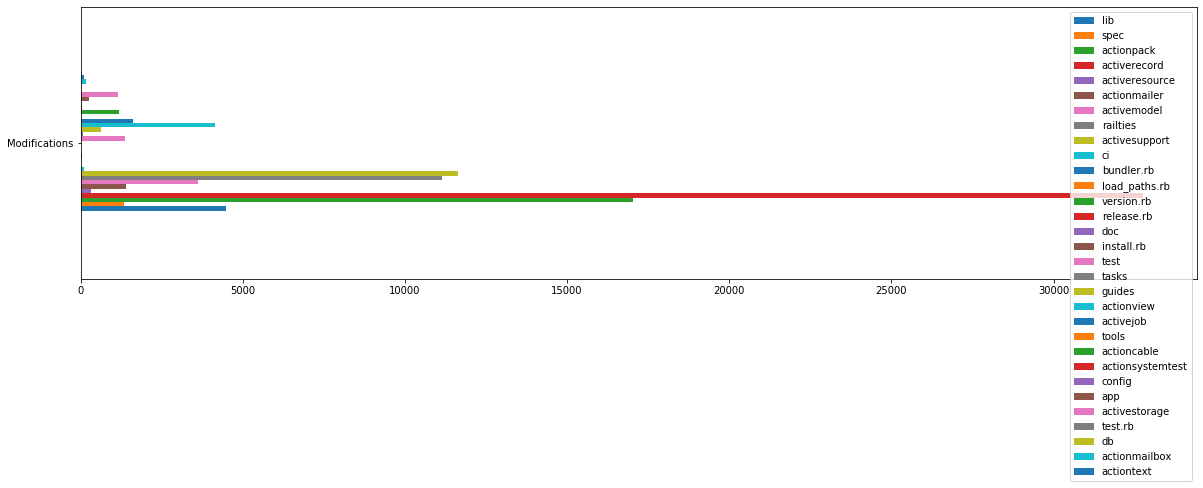

In [191]:
import pandas as pd
df = pd.DataFrame(components_with_total_modifications, index=['Modifications'])
ax = df.plot.barh(figsize=(20,5))

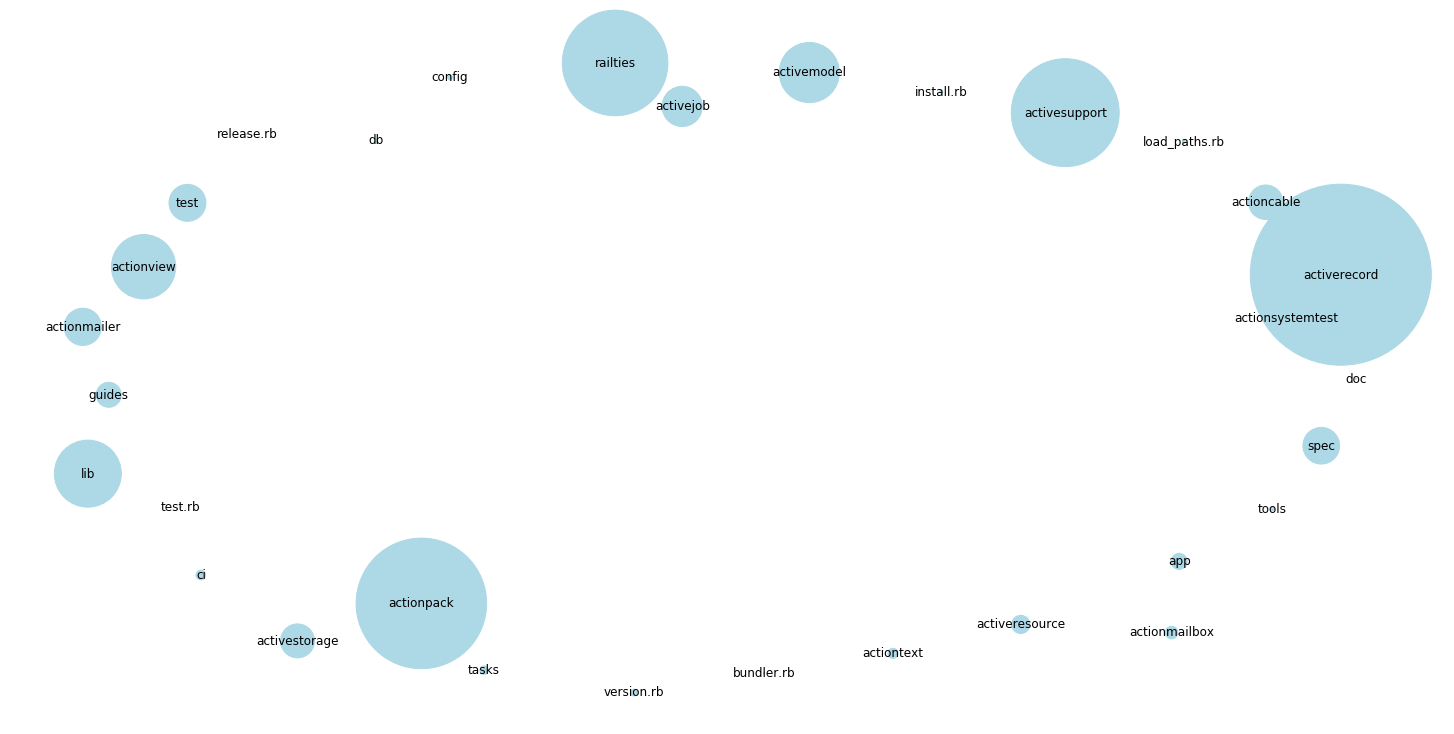

In [187]:
draw_graph_with_weights(modifications_graph(), lambda c: components_with_total_modifications[c])